In [37]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
%cd /content/drive/My\ Drive/probability_csv_folder

/content/drive/.shortcut-targets-by-id/1V6wbdNpPOa_r9A93AQDO5rO61_1ta8Lr/probability_csv_folder


### Read the probability predict results of all four basic model

In [40]:
file_list = os.listdir('.')
df_name_list =[]
for file in file_list:
  df_name_list.append(file.split('.')[0])

In [41]:
df_name_list

['roberta_preds_prob',
 'xlnet_preds_prob',
 'biLSTM_preds_prob',
 'bert_preds_prob',
 'y_true',
 'bert_y_preds',
 'bert_preds_prob(12:7)']

In [43]:
pred_roberta_p = pd.read_csv('roberta_preds_prob.csv')
pred_xlnet_p = pd.read_csv('xlnet_preds_prob.csv')
pred_bert_p = pd.read_csv('bert_preds_prob_1207.csv')
pred_bilstm_p = pd.read_csv('biLSTM_preds_prob.csv')


### Check the probability results of four models

In [76]:
conc_proba_p = pd.concat([pred_roberta_p,pred_xlnet_p, pred_bert_p,pred_bilstm_p], axis=1)

In [77]:
conc_proba_p.head()

,Unnamed: 0,pred_0,pred_1,Unnamed: 0,pred_0,pred_1,Unnamed: 0,pred_0,pred_1,Unnamed: 0,pred_0,pred_1
0,0.0,0.969243,0.042204,0.0,0.973987,0.024103,0.0,0.925572,0.158969,0,0.525878,0.474122
1,1.0,0.965642,0.046128,1.0,0.966399,0.015245,1.0,0.904354,0.130083,1,0.809459,0.190541
2,2.0,0.015407,0.982911,2.0,0.007872,0.993223,2.0,0.034195,0.963596,2,0.041580,0.958421
3,3.0,0.969495,0.041924,3.0,0.972180,0.023591,3.0,0.933672,0.110399,3,0.067185,0.932815
4,4.0,0.015064,0.983432,4.0,0.007003,0.994885,4.0,0.029767,0.974017,4,0.956174,0.043826


In [78]:
conc_proba_p.tail()

,Unnamed: 0,pred_0,pred_1,Unnamed: 0,pred_0,pred_1,Unnamed: 0,pred_0,pred_1,Unnamed: 0,pred_0,pred_1
5656,5656.0,0.043537,0.946021,5656.0,0.038064,0.904299,5656.0,0.857645,0.373698,5656,0.411185,0.588815
5657,5657.0,0.193095,0.768807,5657.0,0.910328,0.164468,5657.0,0.929164,0.116048,5657,0.944436,0.055564
5658,5658.0,0.969287,0.042103,5658.0,0.968403,0.018615,5658.0,0.933515,0.120223,5658,0.070271,0.929729
5659,5659.0,0.967217,0.043980,5659.0,0.961434,0.036847,5659.0,0.919504,0.118620,5659,0.439988,0.560012
5660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5660,0.562378,0.437622


### Get the predict results for Confusion Matrix

In [48]:
def get_pred(pred_p):
  p = pred_p.to_numpy()
  p = p[:,1:]
  p_output = np.argmax(p, axis=1)
  return(p_output)

In [49]:
pred_roberta = get_pred(pred_roberta_p)
pred_xlnet = get_pred(pred_xlnet_p)
pred_bert = get_pred(pred_bert_p)
pred_bilstm = get_pred(pred_bilstm_p)
df_bert = pd.DataFrame(pred_bert)
df_bert.to_csv('bert_y_preds.csv')

In [80]:
pred_bilstm_p.to_numpy()[1:,1:]

array([[0.80945891, 0.19054109],
       [0.04157951, 0.95842052],
       [0.06718491, 0.93281507],
       ...,
       [0.07027149, 0.92972851],
       [0.43998829, 0.56001174],
       [0.56237763, 0.43762237]])

### Soft-Voting

In [83]:
p = pred_roberta_p.to_numpy()[:,1:]+pred_bert_p.to_numpy()[:,1:]+pred_xlnet_p.to_numpy()[:,1:]+pred_bilstm_p.to_numpy()[1:,1:]
pred_ensemble = np.argmax(p,axis = 1)
print(p[:10])
print(pred_ensemble[:10])

[[3.67826115 0.41581699]
 [2.8779747  1.14987688]
 [0.12465903 3.87254519]
 [3.83152022 0.21974004]
 [0.061729   3.94243954]
 [0.12797134 3.85727494]
 [0.10366514 3.89100389]
 [3.57946513 0.50390882]
 [0.12773887 3.85530448]
 [0.19533336 3.797725  ]]
[0 0 1 0 1 1 1 0 1 1]


### Hard-voting

In [57]:
def most_frequent(List): 
    dict = {} 
    count, itm = 0, '' 
    for item in reversed(List): 
        dict[item] = dict.get(item, 0) + 1
        if dict[item] >= count : 
            count, itm = dict[item], item 
    return(itm) 
  

In [93]:
r = len(pred_roberta)
pred_vote=[]
for i in range(r):
  temp = [pred_roberta[i],pred_bert[i],pred_bilstm[i+1],pred_xlnet[i]]
  pred_vote.append(most_frequent(temp))
print(len(pred_vote))

5660


### Predict Accuracy and Confusion Matrix

In [99]:
def acc(preds,labels,model_name):
  cnt = 0
  for pred,label in zip(preds,labels):
    if(pred == label):
      cnt +=1
  acc_ensemble = cnt/len(labels)
  print(f'accuracy of {model_name} is: {acc_ensemble:.4f}')
  return(acc_ensemble)


In [100]:


def cm(labels,pred,model_name):
  cnf_mat = confusion_matrix(labels, pred)

  abbreviations=['negative','positive']
  fig, ax = plt.subplots(1)
  ax = sns.heatmap(cnf_mat, ax=ax, cmap=plt.cm.Blues, annot=True, fmt='g',annot_kws={'size':16})
  ax.set_xticklabels(abbreviations)
  ax.set_yticklabels(abbreviations)
  plt.title(f'CM of {model_name}')
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.show()

In [101]:
y_true = pd.read_csv('/content/drive/My Drive/probability_csv_folder/y_true.csv')
y_true = y_true.to_numpy()[:,1]
print(y_true[:10])

[0 0 1 0 1 1 1 0 1 1]


In [102]:
acc_soft_voting=acc(pred_ensemble,y_true,'Soft-voting')
acc_hard_voting = acc(pred_vote,y_true,'Hard-voting')
acc_bert = acc(pred_bert,y_true,'Bert')
acc_roberta = acc(pred_roberta,y_true,'Roberta')
acc_xlnet = acc(pred_xlnet,y_true,'XLNet')
acc_bilstm = acc(pred_bilstm,y_true,'BiLSTM')


accuracy of Soft-voting is: 0.9159
accuracy of Hard-voting is: 0.9138
accuracy of Bert is: 0.9083
accuracy of Roberta is: 0.9094
accuracy of XLNet is: 0.9154
accuracy of BiLSTM is: 0.6970


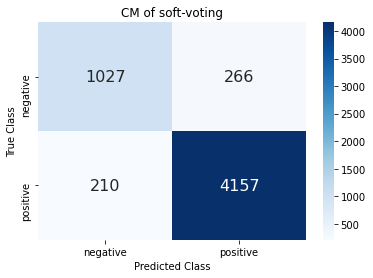

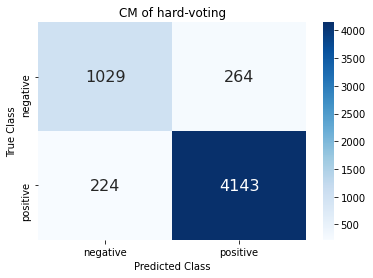

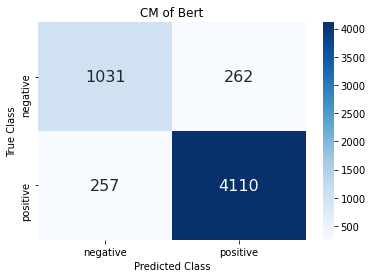

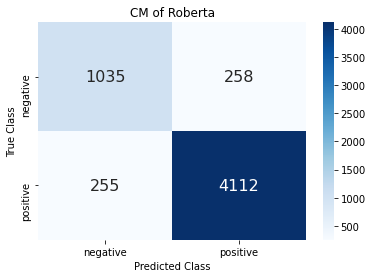

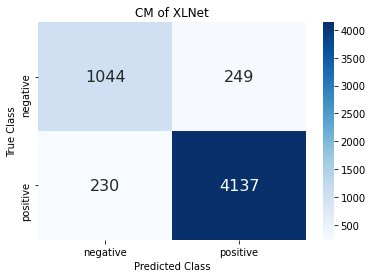

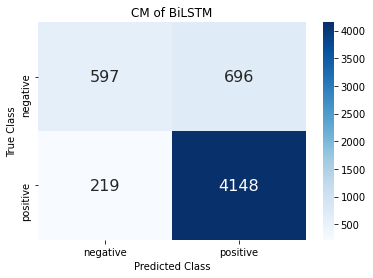

In [98]:
cm(y_true, pred_ensemble,'soft-voting')
cm(y_true,pred_vote,'hard-voting')
cm(y_true,pred_bert,'Bert')
cm(y_true,pred_roberta,'Roberta')
cm(y_true,pred_xlnet,'XLNet')
cm(y_true,pred_bilstm[1:],'BiLSTM')


In [110]:
from sklearn.metrics import precision_score

def print_precision(y_true, y_pred, model_name):
  score = precision_score(y_true, y_pred, average='micro')
  print(f'the precision score of {model_name} is:{score:.3f} ')


In [111]:
print_precision(y_true, pred_ensemble,'soft-voting')
print_precision(y_true,pred_vote,'hard-voting')
print_precision(y_true,pred_bert,'Bert')
print_precision(y_true,pred_roberta,'Roberta')
print_precision(y_true,pred_xlnet,'XLNet')
print_precision(y_true,pred_bilstm[1:],'BiLSTM')

the precision score of soft-voting is:0.916 
the precision score of hard-voting is:0.914 
the precision score of Bert is:0.908 
the precision score of Roberta is:0.909 
the precision score of XLNet is:0.915 
the precision score of BiLSTM is:0.838 
